In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch 
import pytorch_lightning as pl
import utils

# Data Exploration

In [2]:
iRT_noMods = pd.read_csv(r"sequence_iRT.tsv", sep="\t")

#save the dataframe as tsv without last three rows after sorting by iRT(Scan Retention Time)
iRT_noMods.sort_values(by="Scan Retention Time", inplace=True)
iRT_noMods = iRT_noMods.iloc[:-3]
iRT_noMods.to_csv("sequence_iRT_noMods_wihoutBiggestThree.tsv", sep="\t", index=False)

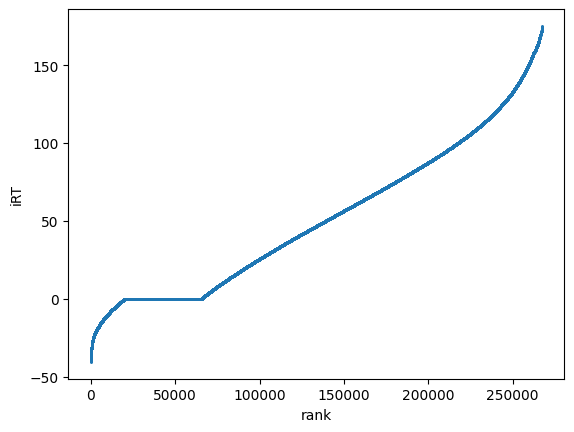

In [3]:
#order data by second column and plot 
iRT_noMods = iRT_noMods.sort_values(by="Scan Retention Time")
#drop las three points
iRT_noMods = iRT_noMods.iloc[:-3]

plt.scatter(range(len(iRT_noMods["Scan Retention Time"])), iRT_noMods["Scan Retention Time"], s=0.5)
plt.xlabel("rank")
plt.ylabel("iRT")
plt.show()

# Model 1

In [4]:
# # Load the data
# data = pd.read_excel("41467_2021_23713_MOESM4_ESM.xlsx", sheet_name = "Identifications")
# sequence_iRT = data[["Sequence", "Average iRT"]]
# #rename columns to Full Sequence and Scan Retention Time
# sequence_iRT.columns = ["Full Sequence", "Scan Retention Time"]
# #save as csv
# sequence_iRT.to_csv("sequence_iRT.tsv", index = False, sep="\t")
vocab = utils.Tokenizer.readVocabulary("SimpleVocab.csv")

#tokenize the data
training, validation, testing = utils.Tokenizer.run_tokenizer(filePath="sequence_iRT_noMods_wihoutBiggestThree.tsv",
                                        vocabPath="SimpleVocab.csv", 
                                            sequenceLength=50,
                                                tokenFormat= utils.TokenFormat.OneDimNoMod)

#make them dataloaders
training = torch.utils.data.DataLoader(training, batch_size=128, shuffle=True, drop_last=True)
validation = torch.utils.data.DataLoader(validation, batch_size=128, shuffle=False, drop_last=True)
testing = torch.utils.data.DataLoader(testing, batch_size=128, shuffle=False, drop_last=True)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\utils.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\utils.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[1]))


In [12]:
epoch = 0
val_epoch = 0

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride)
        self.batchNorm1 = nn.BatchNorm1d(out_channels)
        self.batchNorm2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

        #init weights
        nn.init.kaiming_normal_(self.conv1.weight, mode="fan_out")
        nn.init.kaiming_normal_(self.conv2.weight, mode="fan_out")
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = nn.functional.pad(x, (0, 4))
        x += residual
        x = self.relu(x)
        return x

#class for the model, includes attention layer
class iRT_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), 128, 0)
        self.resnet1 = ResnetBlock(128, 128, 3, 1)
        self.resnet2 = ResnetBlock(128, 128, 3, 1)
        self.resnet3 = ResnetBlock(128, 128, 3, 1)
        self.attention = nn.MultiheadAttention(128, 32, 0.1)
        self.lstm1 = nn.LSTM(128, 128, 5, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten(start_dim=1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(128, 50)
        self.lastLinear = nn.Linear(2500, 1)
        self.double()

        #init weights
        nn.init.kaiming_normal_(self.linear.weight)
        nn.init.kaiming_normal_(self.lastLinear.weight)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        # x = x.permute(0, 2, 1)
        x = self.resnet1(x)
        x = self.resnet2(x)
        x = self.resnet3(x)
        x = self.dropout(x)
        attn_out, attn_w = self.attention(x, x, x)
        x, _ = self.lstm1(x)
        # x = torch.matmul(attn_out, x)
        # x = self.relu(x)
        # x = self.flatten(x)
        x = self.linear(x)
        # merge dim 1 and 2 to end go from 3d to 2d
        x = x.reshape(x.size(1), x.size(0) * x.size(2))
        #down to 1 dimension
        x = self.relu(x)
        x = self.lastLinear(x)
        return x

#class for pytorch_lighning module (for training)
class iRT_CNN_PL(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y.unsqueeze(1))
        self.log("train_loss", loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y.unsqueeze(1))
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y.unsqueeze(1))
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

    def lr_scheduler_step(self, scheduler, metric):
        scheduler.step()

In [13]:
#check dataloaders
for x, y in training:
    print(x.shape)
    print(y.shape)
    break

for x, y in validation:
    print(x.shape)
    print(y.shape)
    break

for x, y in testing:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 50])
torch.Size([128])
torch.Size([128, 50])
torch.Size([128])
torch.Size([128, 50])
torch.Size([128])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | iRT_CNN | 1.1 M 
1 | loss  | MSELoss | 0     
----------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.245     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1670/1670 [03:32<00:00,  7.87it/s, v_num=168, val_loss=2.27e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1670/1670 [03:32<00:00,  7.87it/s, v_num=168, val_loss=2.27e+3]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 208/208 [00:11<00:00, 18.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2315.9087805093927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
iRT_model_004_128emb.pth
Training complete


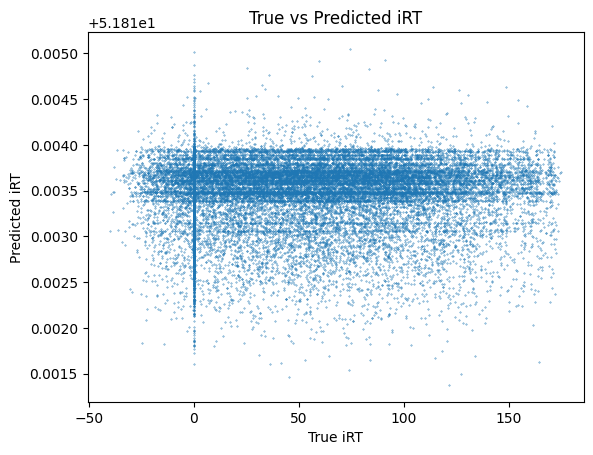

In [14]:
model = iRT_CNN()
pl_model = iRT_CNN_PL(model)
trainer = pl.Trainer(max_epochs=100)

trainer.fit(pl_model, training, validation)
trainer.test(pl_model, testing)
torch.save(model.state_dict(), "iRT_model_004_128emb.pth")

#test the model
labels = []
flat_labels = []
preds = []
flat_preds = []

model.eval()
for i, (x, y) in enumerate(testing):
    y_hat = model(x)
    preds.append(y_hat.tolist())
    labels.append(y.tolist())
#flatten the lists
for sublist in labels:
    for item in sublist:
        flat_labels.append(item)
for sublist in preds:
    for item in sublist:
        flat_preds.append(item)

plt.scatter(flat_labels, flat_preds, s=0.1)
plt.xlabel("True iRT")
plt.ylabel("Predicted iRT")
plt.title("True vs Predicted iRT")
plt.savefig("iRT_model_004_128emb.png")

print("iRT_model_004_128emb.pth")
print("Training complete")

# Attention Net - iRT/basic residues